# CatBoost with automatic cross-validated optimization

**Example using the catboost_auto function in the EasyMLR module**

The **catboost_auto** function in the EasyMLR module automatically finds the optimum set of cross-validated hyper-parameters and then outputs the fitted regression model and summary statistics using CatBoost with optuna.

The **catboost_auto** function standardizes the X input by default. 

This example shows how to check the cross-validation of the model with independent training and testing data subsets before fitting the final model with all of the data.

#### Example data set

This example uses the diabetes data described in the following tutorial by sklearn:

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py

Before running this notebook, first install the EasyMLR module in your environment, if it is not already installed, using the following line in the next cell:

In [1]:
# !pip install git+https://github.com/gjpelletier/EasyMLR.git --upgrade

## Read X and y from the sklearn diabetes data set

In [2]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True, as_frame=True)

## Split X and y into cross-validation train and test subsets

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the model with the training data subset

In the next step, we will automatically find the best cross-validated hyper-parameters for CatBoost using optuna. Then we will fit the model using the training data with the best parameters. 

After this training step is completed, proceed to the next step to check how well the predictions from the training data match the predictions using the testing data. 

In [ ]:
from EasyMLR import catboost_auto
train_model, train_output = catboost_auto(X_train, y_train,
    # [min, max] range of params that are optimized by optuna
    random_state= 42,                 # random seed for reproducibility
    n_trials= 50,                     # number of optuna trials
    learning_rate= [0.01, 0.3],       # Balances step size in gradient updates.
    depth= [4, 10],                   # Controls tree depth
    iterations= [100, 3000],          # Number of boosting iterations
    l2_leaf_reg= [1, 10],             # Regularization strength       
    random_strength= [0, 1],          # Adds noise for diversity
    bagging_temperature= [0.1, 1.0],  # Controls randomness in sampling
    border_count= [32, 255],          # Number of bins for feature discretization
    min_data_in_leaf= [1, 100],       # Minimum samples per leaf         
    max_bin= [64, 255],               # Number of bins for feature quantization
    )

Running optuna to find best parameters, could take a few minutes, please wait...


## Test the model with the testing data subset

In the next step we will check how well the predictions from fitted model match samples from the testing data. To standardize the testing data we will use the same scaler that was used to standardized the training data to avoid data leakage between the training and testing data.

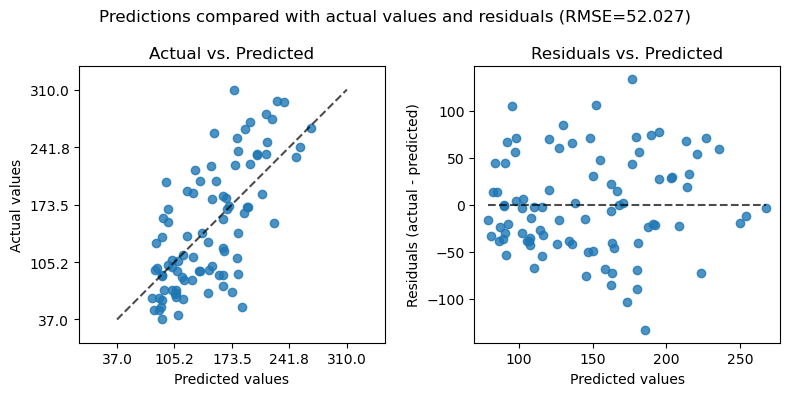

In [5]:
from EasyMLR import plot_predictions_from_test
fig = plot_predictions_from_test(train_model, X_test, y_test, scaler=train_output['scaler'])
fig.savefig("CatBoostRegressor_predictions_test.png", dpi=300)

## Final fit of the model using all of the X and y data

In the next step we will use the best parameters from the training model to fit the model using all of the X and y data.

Fitting CatBoostRegressor model, please wait ...

CatBoostRegressor statistics of fitted model in model_outputs['stats']:

| Statistic   |   CatBoostRegressor |
|:------------|--------------------:|
| r-squared   |              0.7804 |
| RMSE        |             36.0861 |
| n_samples   |            442      |

Done
Time elapsed: 1.15 sec



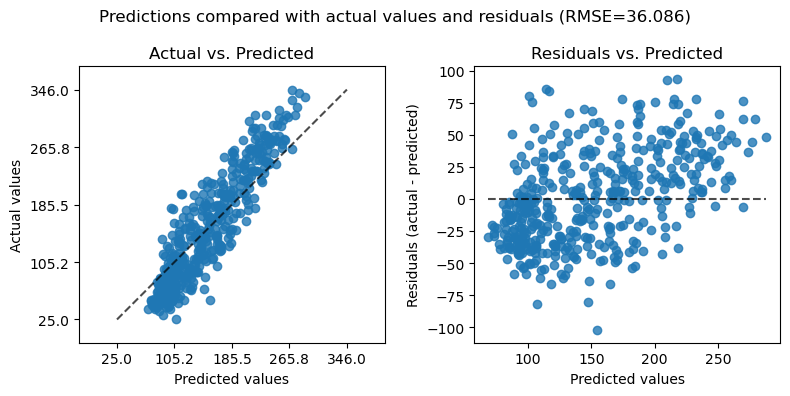

In [6]:
from EasyMLR import catboost
final_model, final_output = catboost(X, y, **train_output['best_params'])

## Display the results of the hyperparameter optimization

The results of the optuna optimization study were saved in the previous step when the model was trained with the training data subset. The output dictionary that we called **train_output** in that step contains a key named **optuna_study** which contains the results of the optimized optuna study. 

In the next step we will use the **show_optuna** function of EasyMLR to display the results of the optimized cross-validated optuna study to show the selected optimum values for the hyperparameters, the optimization history, and the relationships between the hyperparameters and their importance for the scoring criteria.

Best parameters:

learning_rate: 0.015590485318387706
depth: 9
iterations: 208
l2_leaf_reg: 2.1375711628357315
random_strength: 0.7705527185032982
bagging_temperature: 0.805727180792657
min_data_in_leaf: 31
grow_policy: Depthwise
use_border_count: True
border_count: 185

Best score: -56.79245497654023



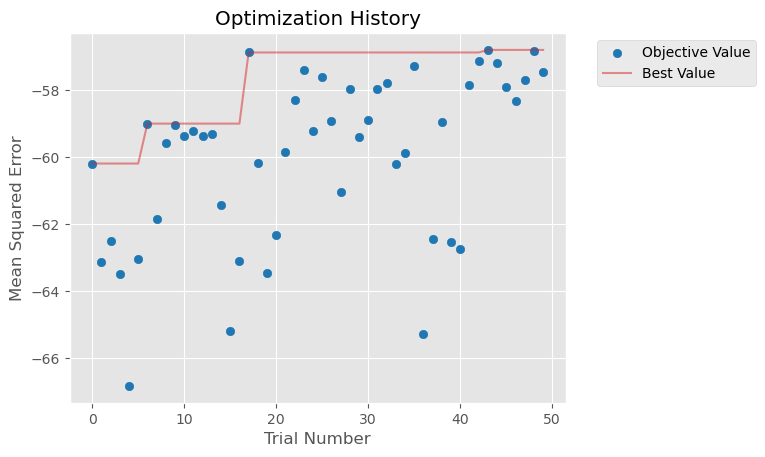

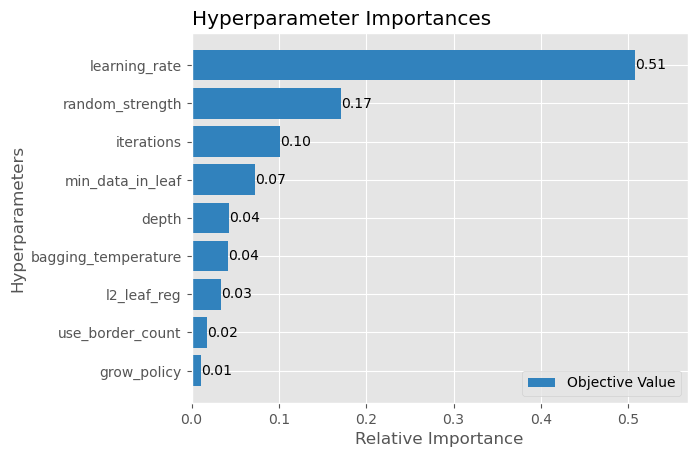

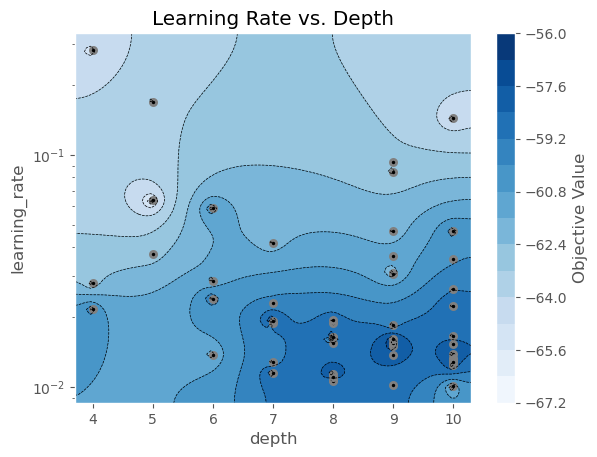

In [7]:
from EasyMLR import show_optuna
show_optuna(train_output['optuna_study'])

## User instructions

In [5]:
help(catboost_auto)

Help on function catboost_auto in module EasyMLR:

catboost_auto(X, y, **kwargs)
    Autocalibration of CatBoostRegressor hyper-parameters
    Beta version

    by
    Greg Pelletier
    gjpelletier@gmail.com
    04-June-2025

    REQUIRED INPUTS (X and y should have same number of rows and
    only contain real numbers)
    X = dataframe of the candidate independent variables
        (as many columns of data as needed)
    y = dataframe of the dependent variable (one column of data)

    OPTIONAL KEYWORD ARGUMENTS
    **kwargs (optional keyword arguments):
        random_state= 42,    # initial random seed
        n_trials= 50,         # number of optuna trials
        standardize= True,    # standardize X
        verbose= 'on',        # 'on' to display summary stats and residual plots
        n_splits= 5,          # number of splits for KFold CV
        gpu= False,           # Autodetect to use gpu if present
        thread_count= -1,     # number of CPU cores to use (-1 for all core